In [1]:
import torch
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

from torch.utils.data import DataLoader
from tqdm import tqdm

from IPython.display import clear_output
import numpy as np
from PIL import Image
import torch.nn as nn
from torch.optim import Adam

from torch.utils.data import Subset



In [2]:
dataset = OxfordIIITPet('./data', target_types='segmentation', download=True)

100%|██████████| 792M/792M [00:23<00:00, 33.6MB/s] 
100%|██████████| 19.2M/19.2M [00:00<00:00, 19.5MB/s]


plt.imshow() интерпретирует числа как цвета разными способами:



## **Посмотрим на изображения**

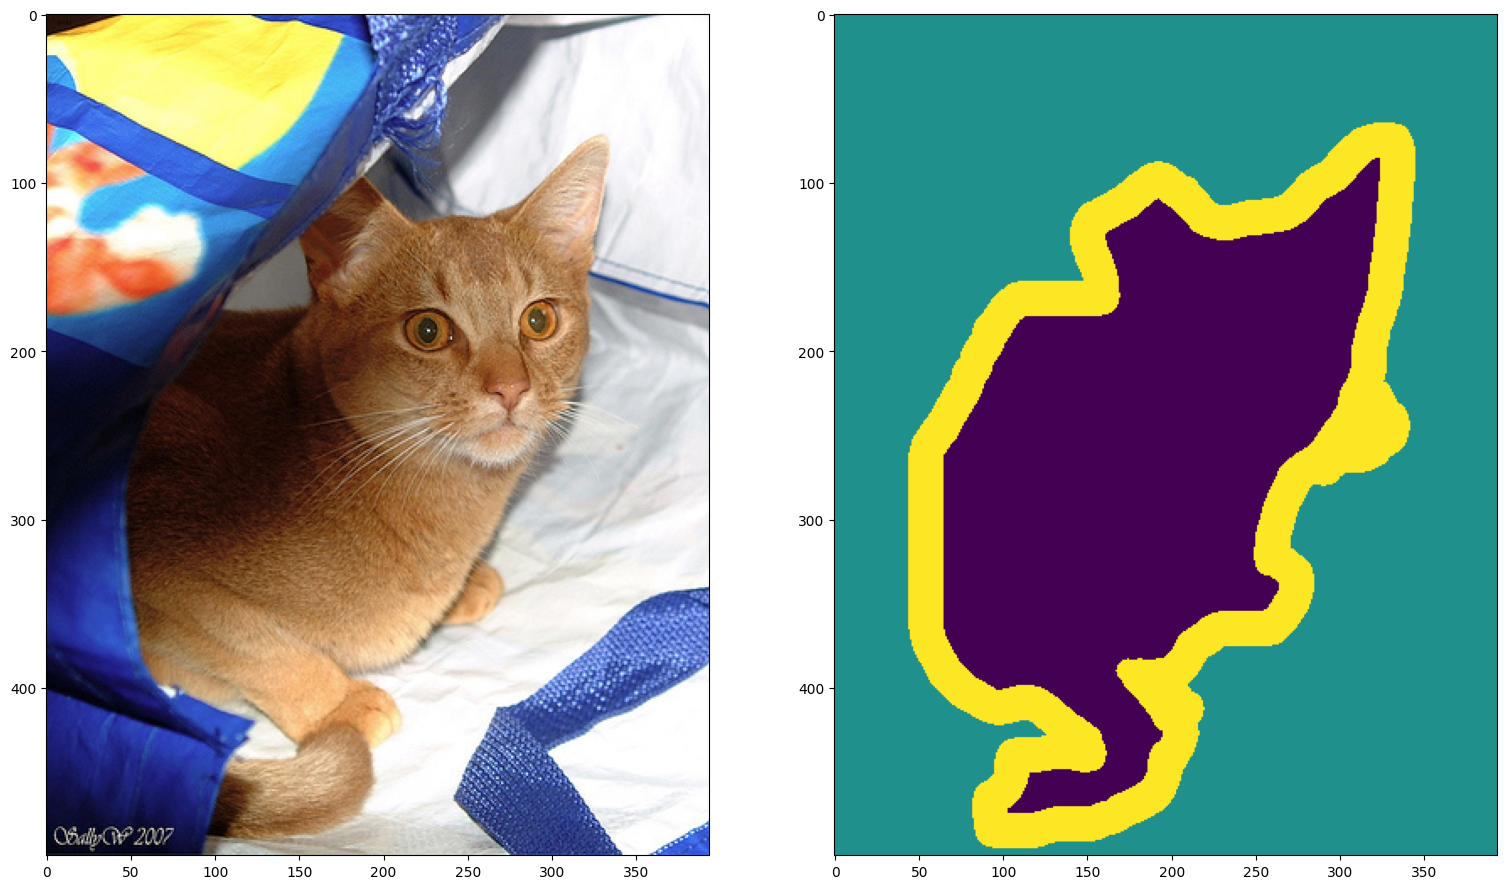

In [3]:
image=  dataset[0][0]
mask = dataset[0][1]

plt.figure(figsize = (16, 9))

plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2 ,2)
plt.imshow(mask)

plt.tight_layout()
plt.show() 

In [4]:
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor()
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('./data', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('./data', transform=transform,split='test',target_transform=target_transform, target_types='segmentation')

In [5]:
#выделяем 200 изображений для тестовой выборки 
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)
valid_subset = Subset(valid_dataset, idx)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_subset, batch_size=64, shuffle=False, pin_memory=True)

In [7]:
def train(model) -> float:
    model.train()

    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    
    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)
        
        x = x.to(device)
        y = y.squeeze(1).to(device)  # Убираем канал у маски
        
        optimizer.zero_grad() #fp
        output = model(x)
        
        loss = loss_fn(
            output.reshape(bs, 3, -1), 
            y.reshape(bs, -1)
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, y_pred = output.max(dim=1)
        total_pixels += y.numel()  # всего пикселей в батче
        correct_pixels += (y == y_pred).sum().item()
    
    train_loss = total_loss / len(train_loader)
    accuracy = correct_pixels / total_pixels
    
    return train_loss, accuracy
        

In [8]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0 
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total
    return total_loss, accuracy


In [9]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [10]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [11]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))
    accuracy = np.mean(valid_accuracy_history)
    print(f'Accuracy on test: {accuracy}')

In [12]:
def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8)

        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)

        residual3 = self.down3(x)
        x = self.downsample(residual3)

        residual4 = self.down4(x)
        x = self.downsample(residual4)

        residual5 = self.down5(x)
        x = self.downsample(residual5)

        # LATENT SPACE DIMENSION DIM = N // 4
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 4

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual5), dim=1)
        x = self.up5(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())
loss_fn=nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [14]:
model = UNET().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

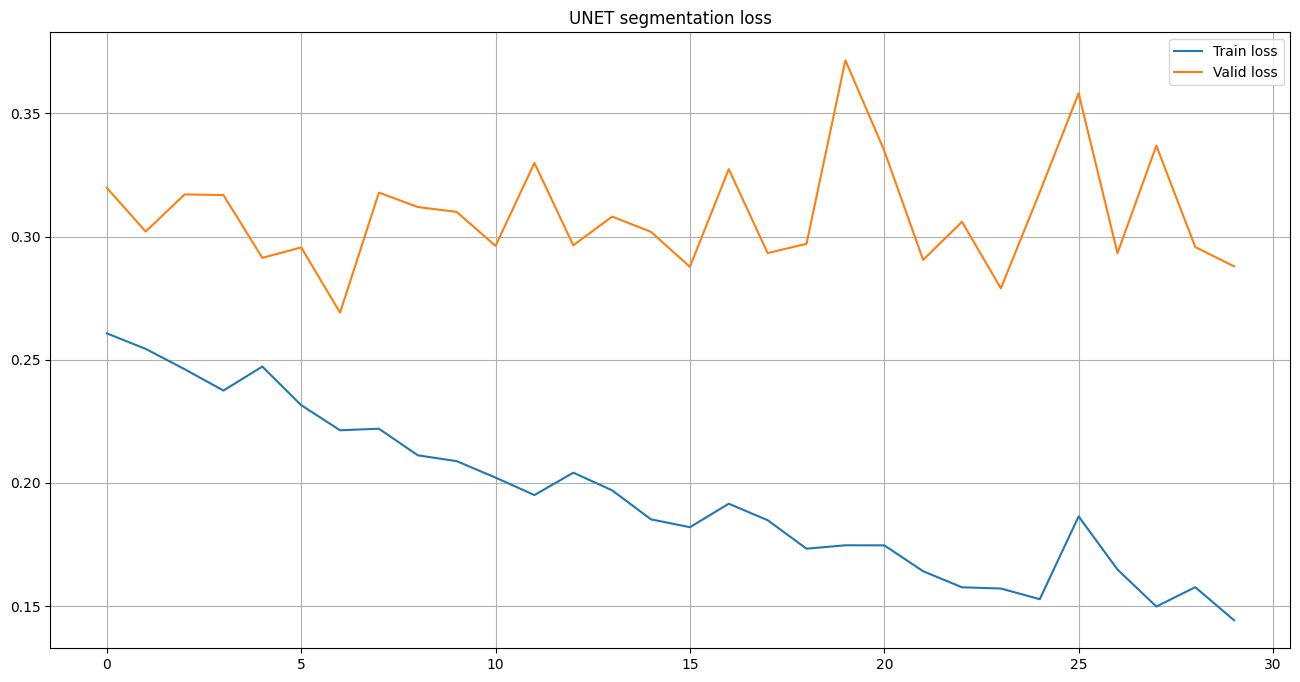

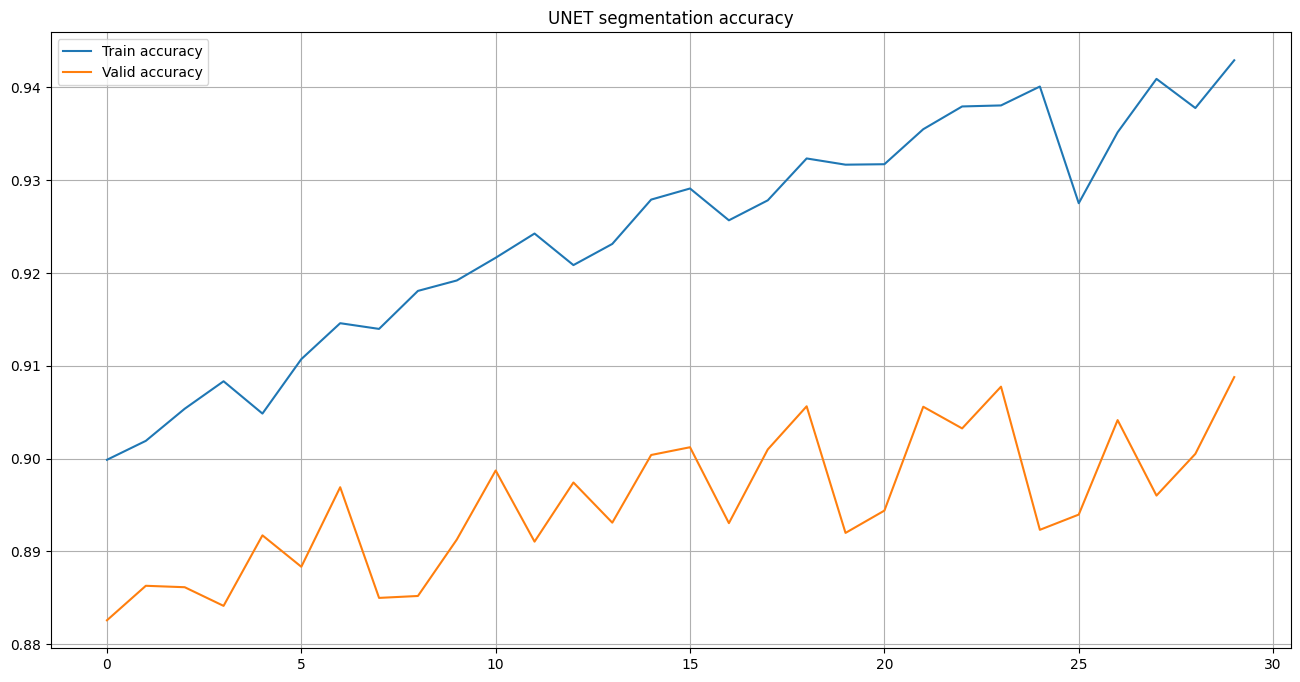

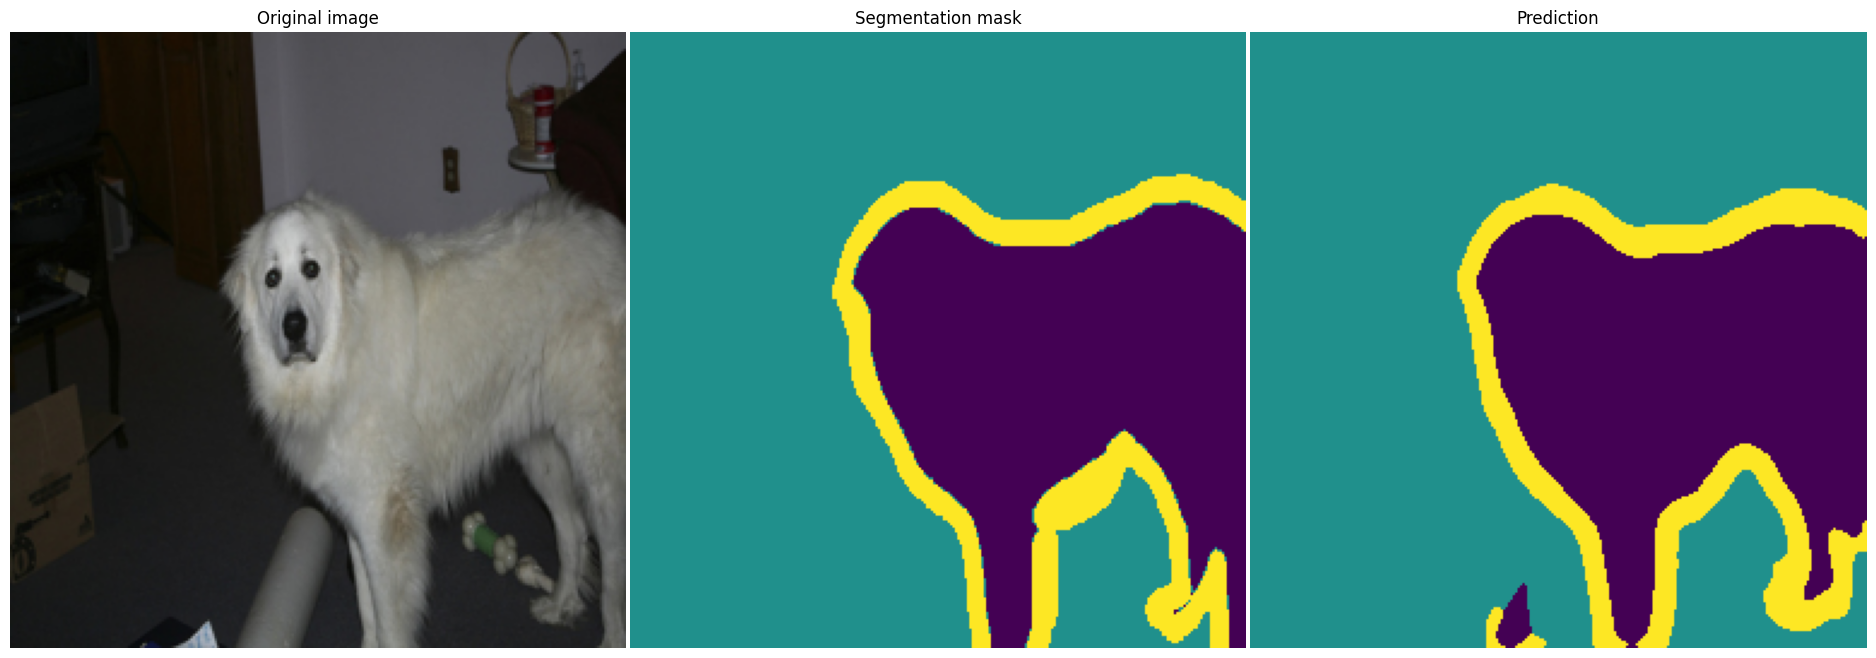

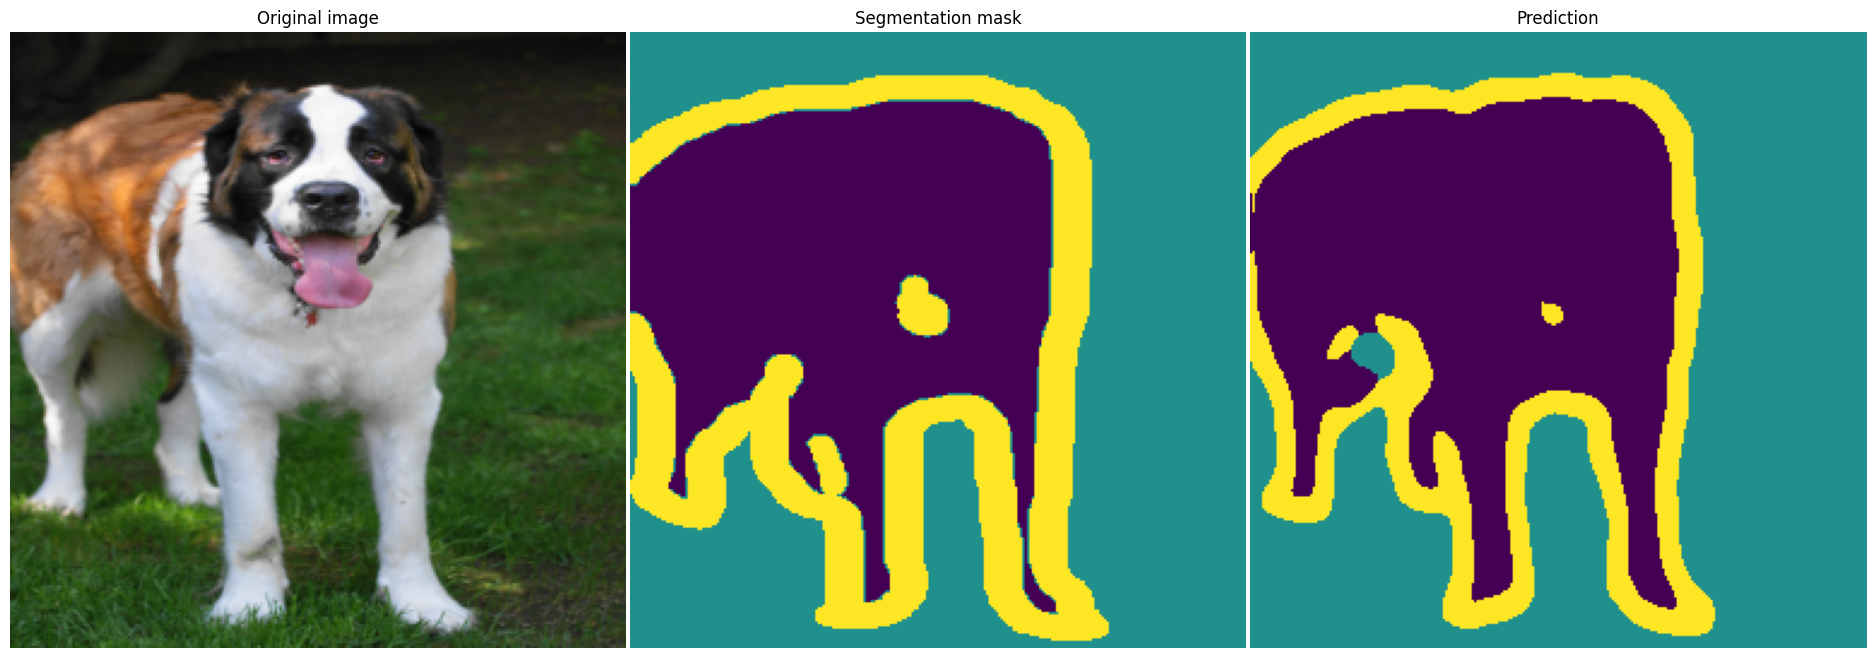

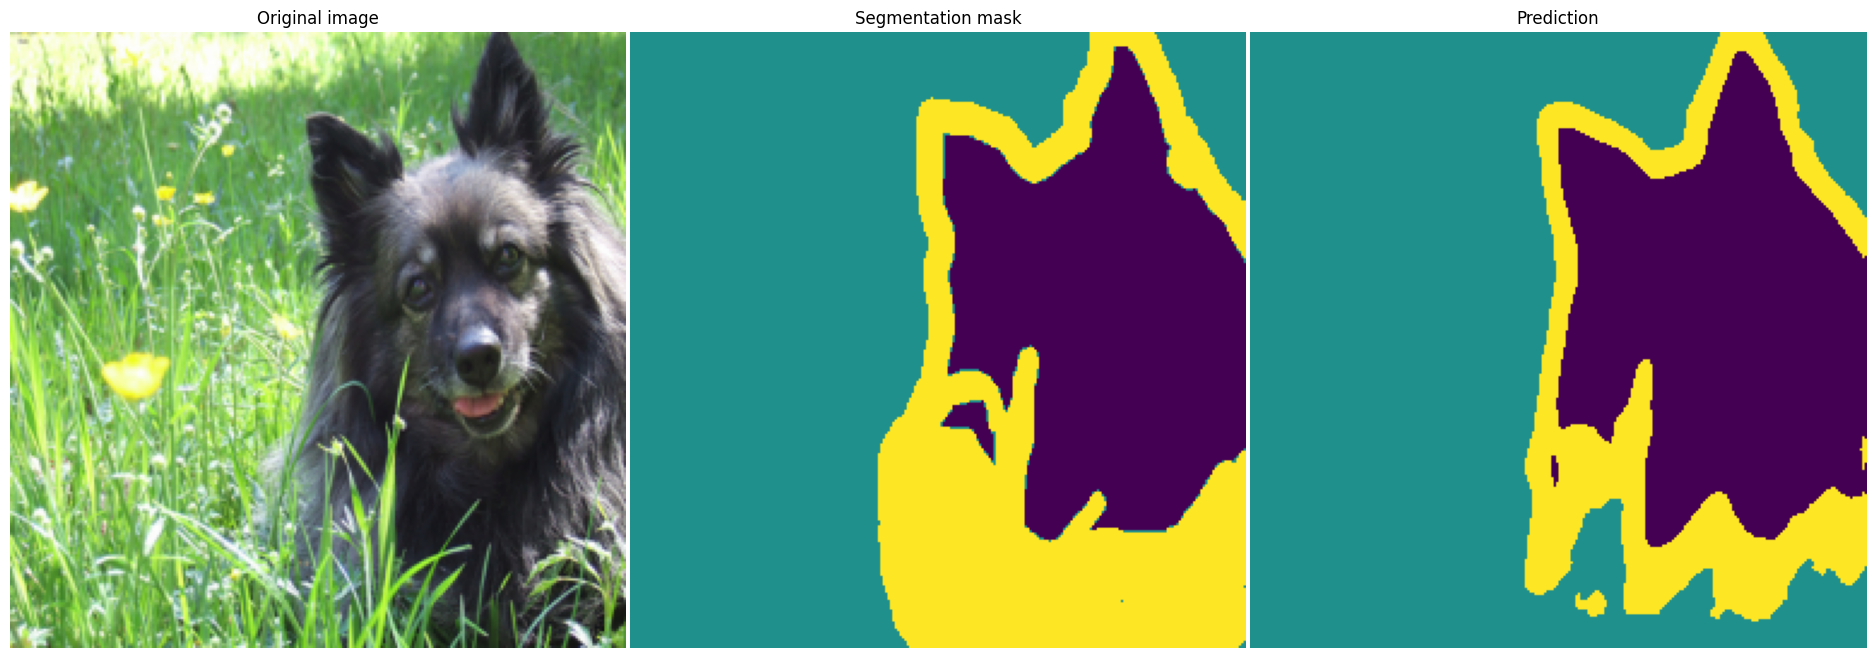

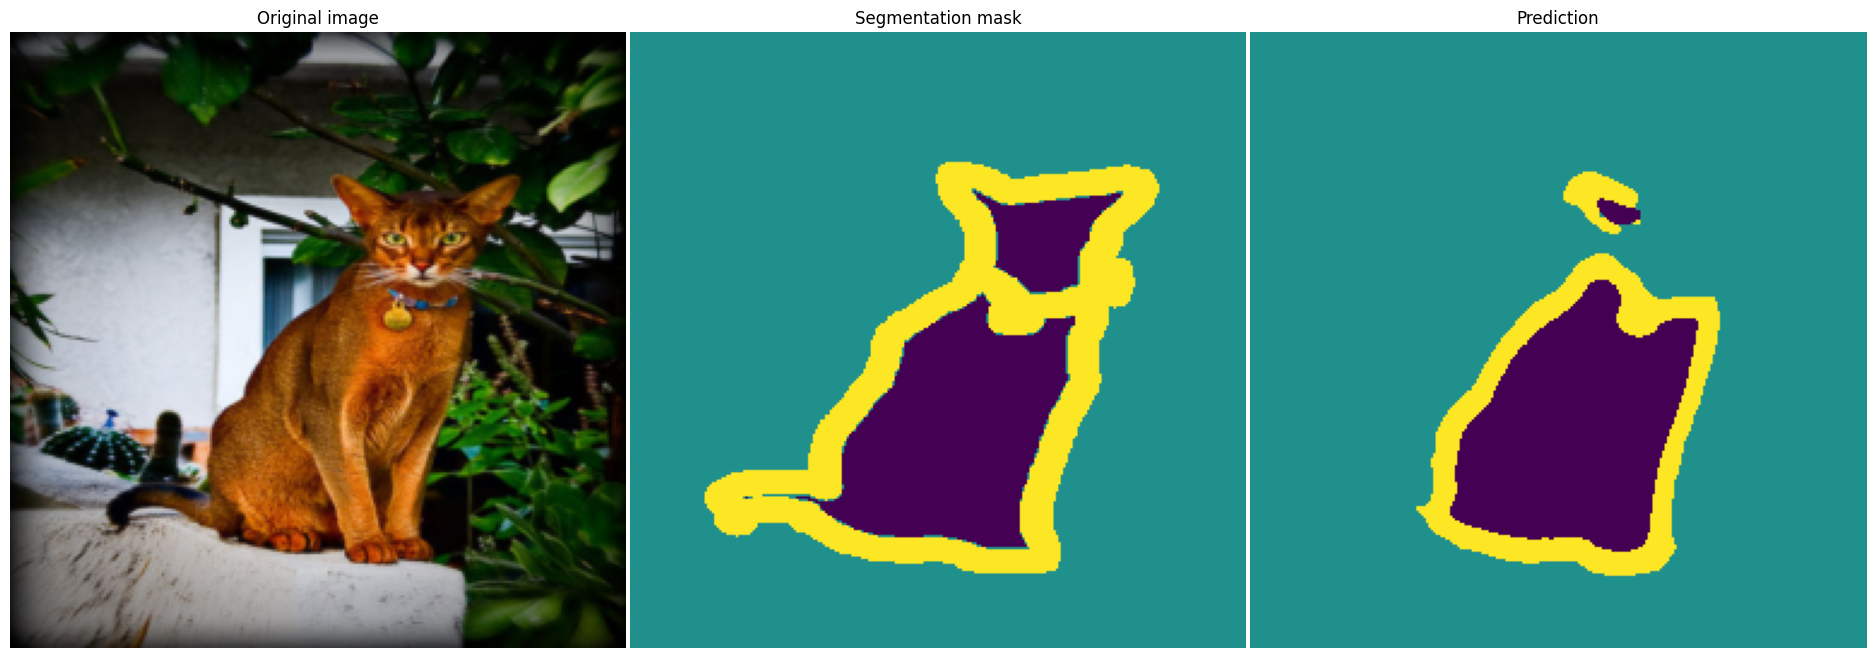

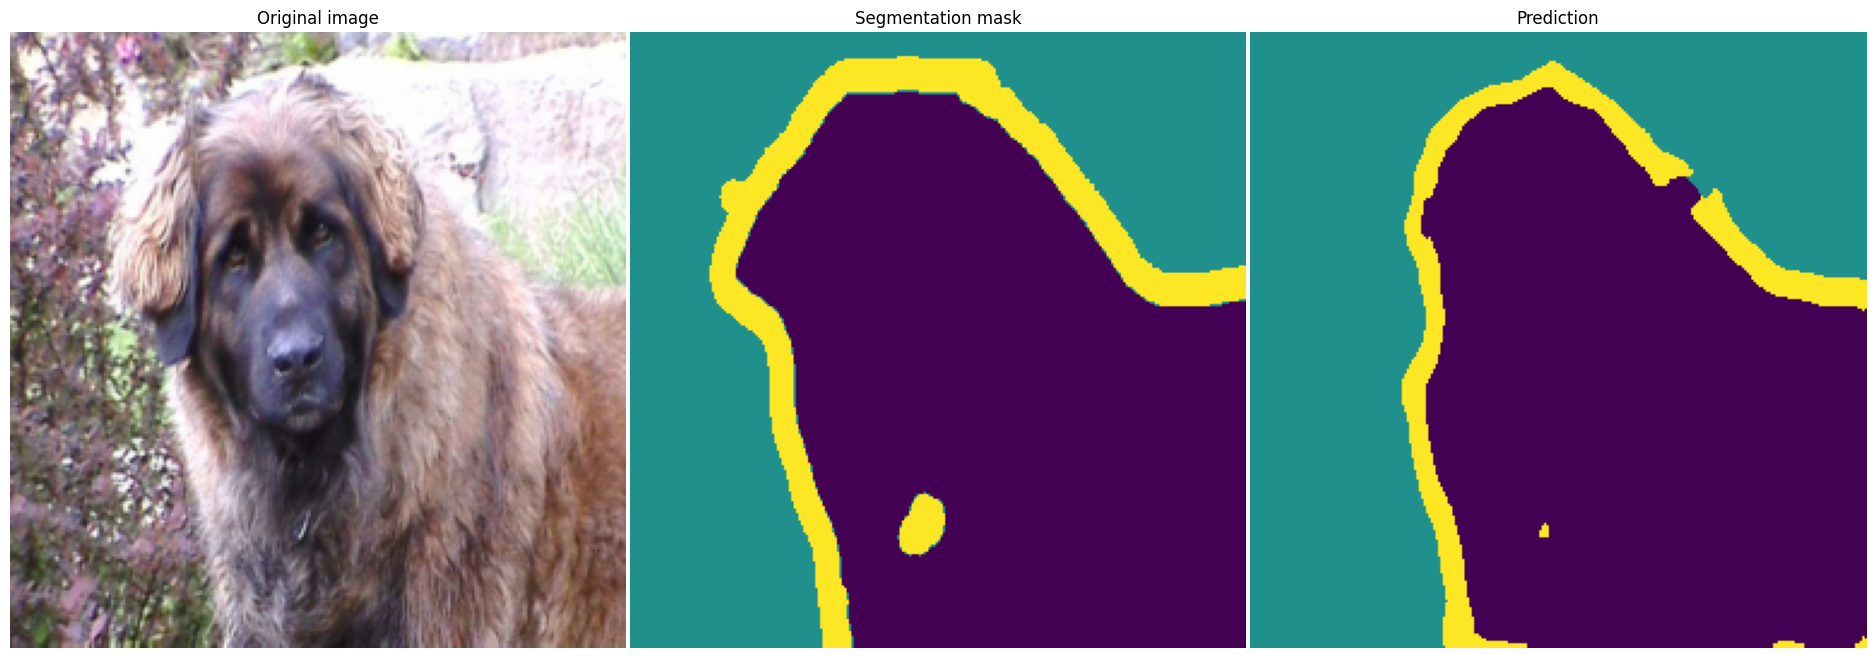

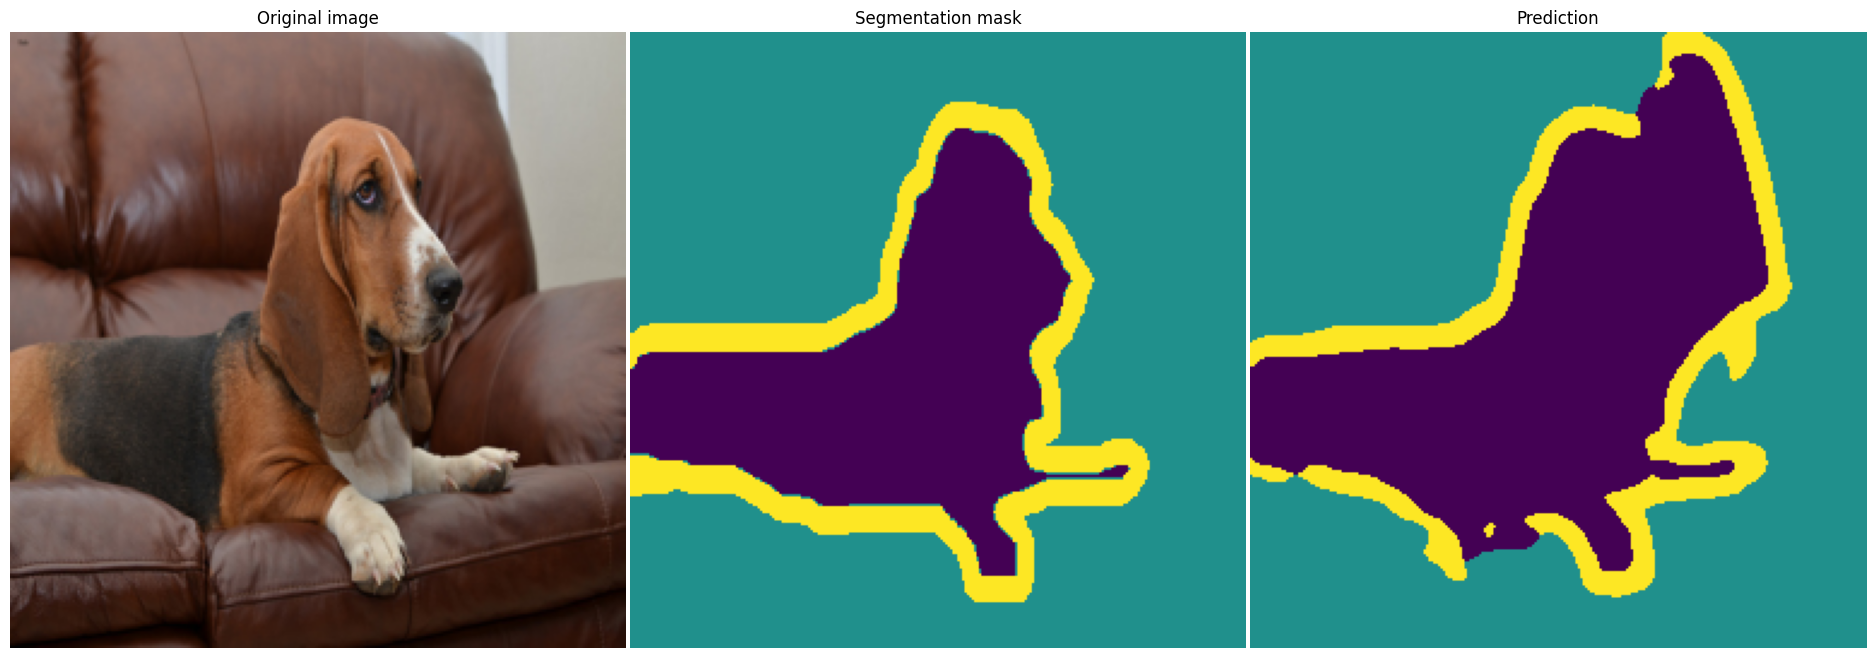

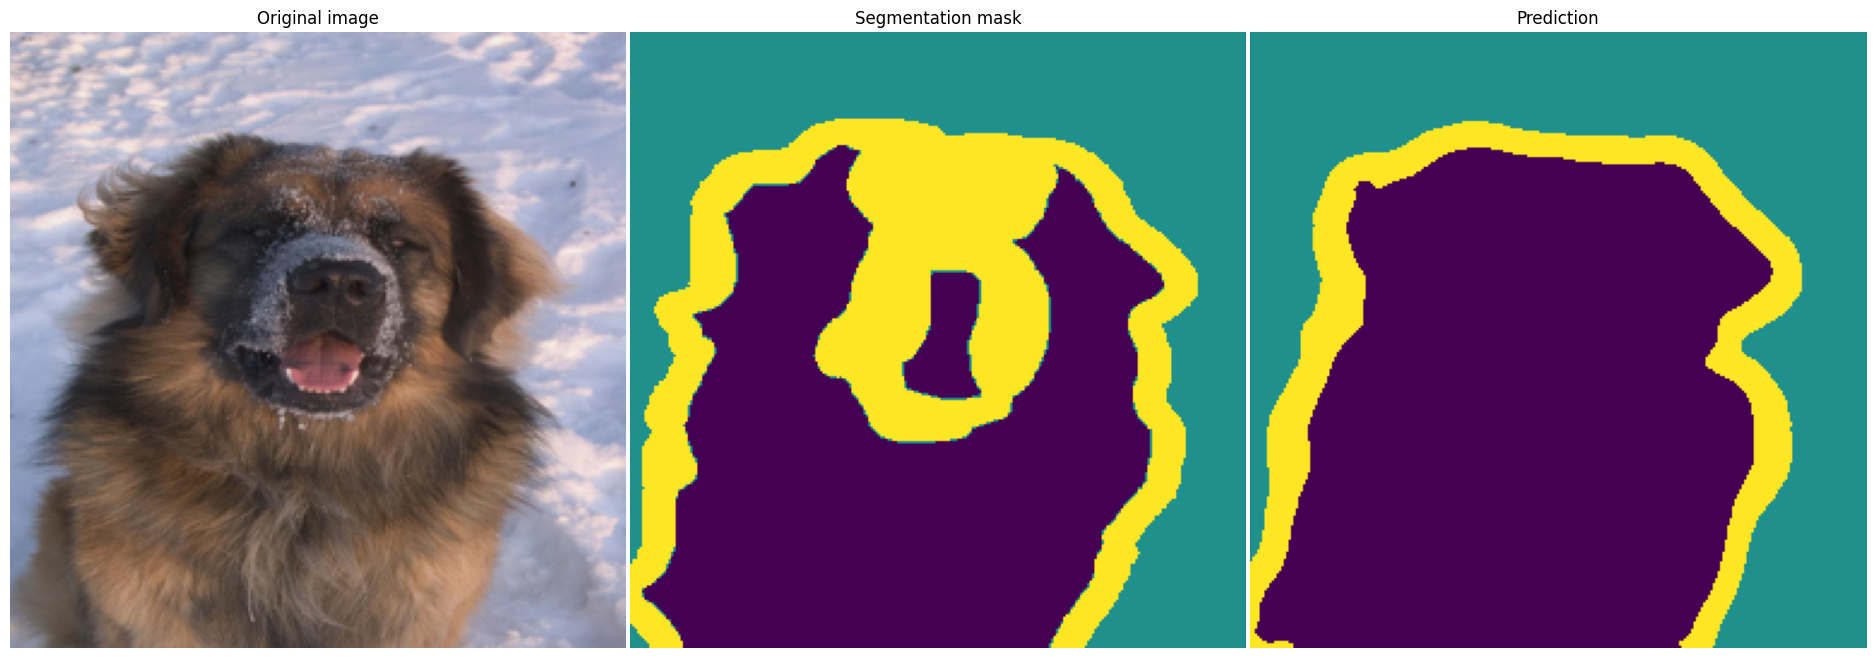

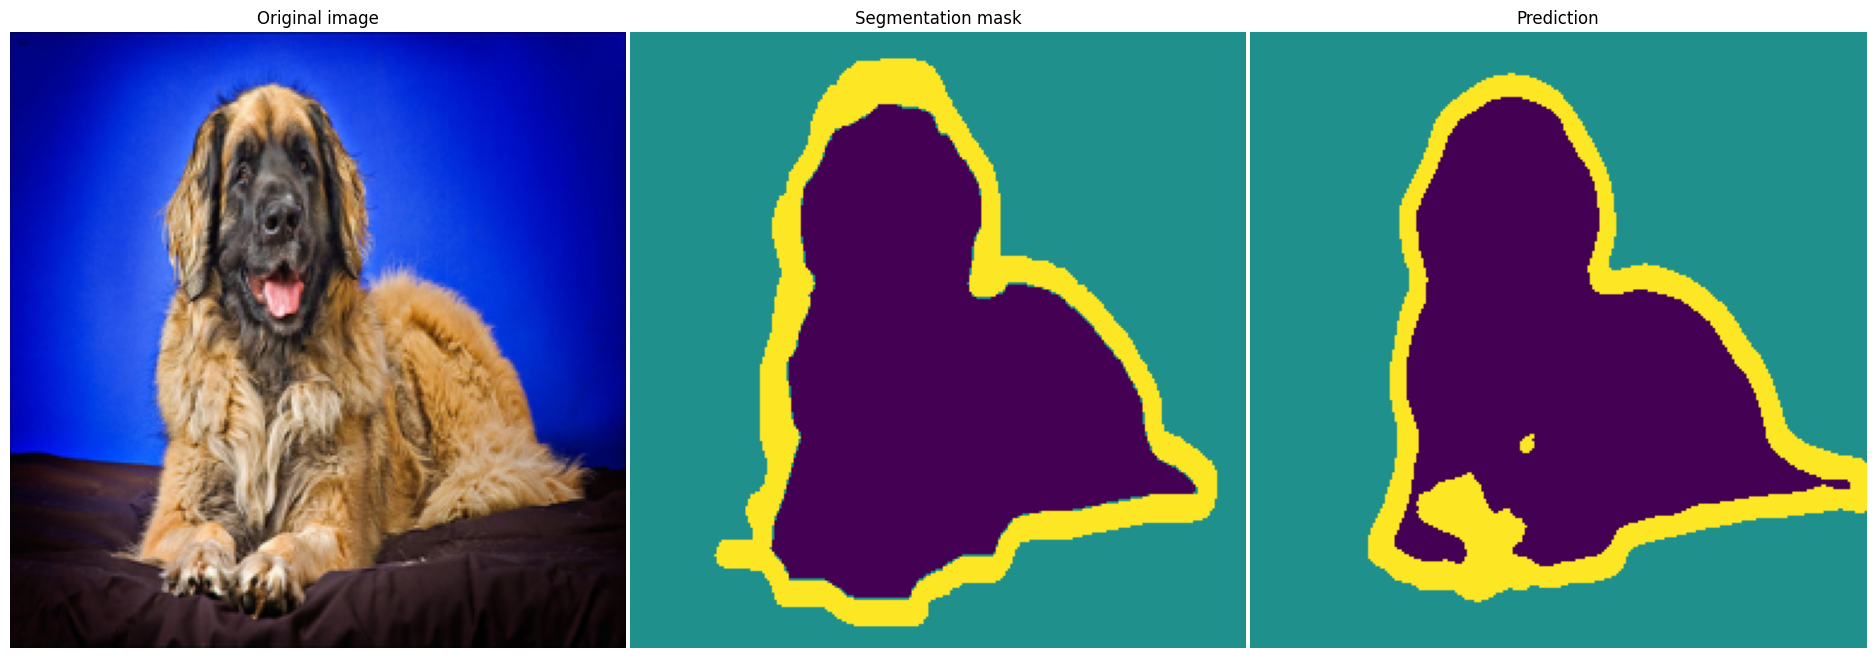

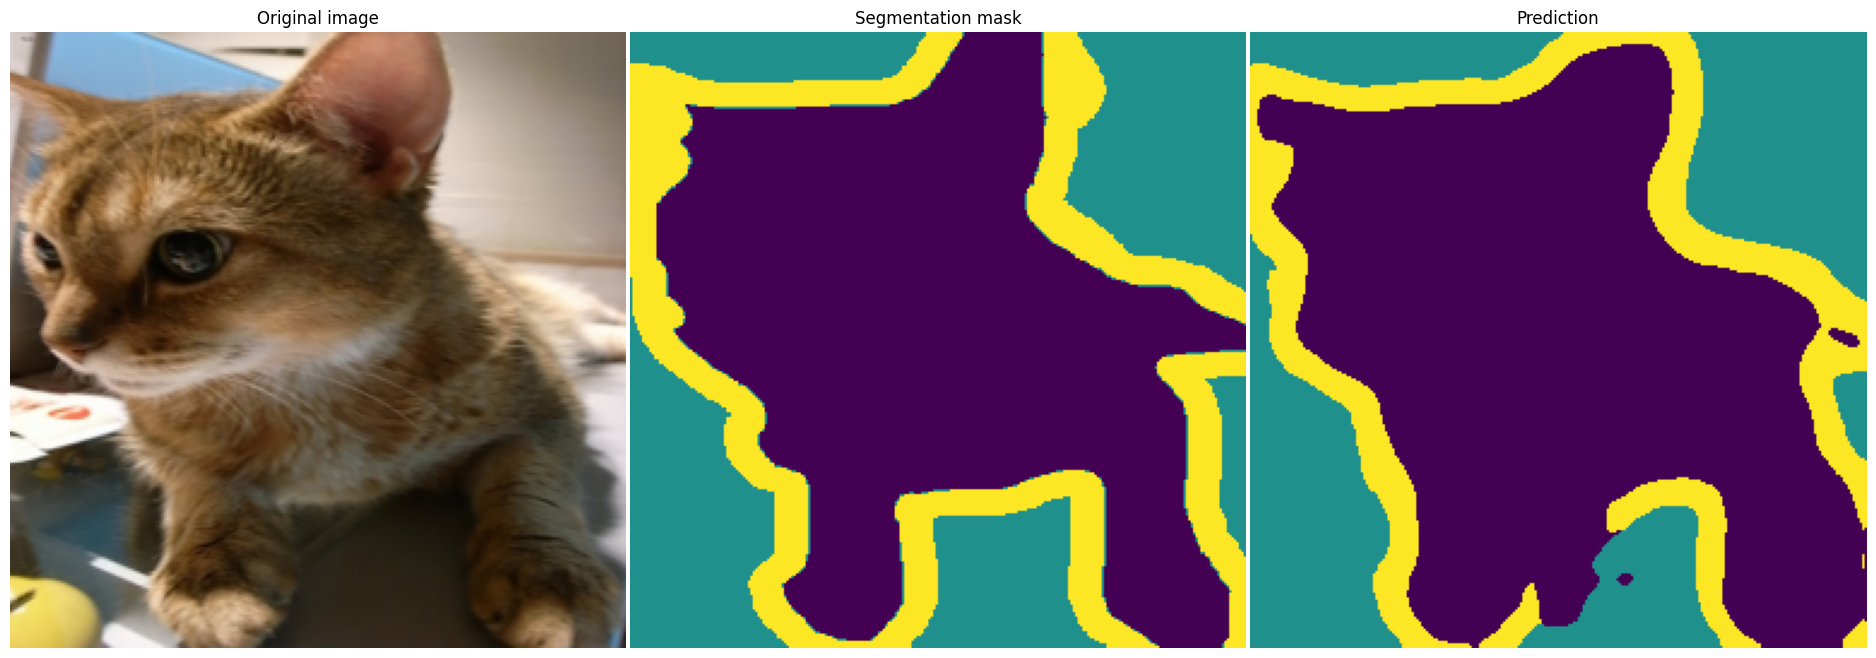

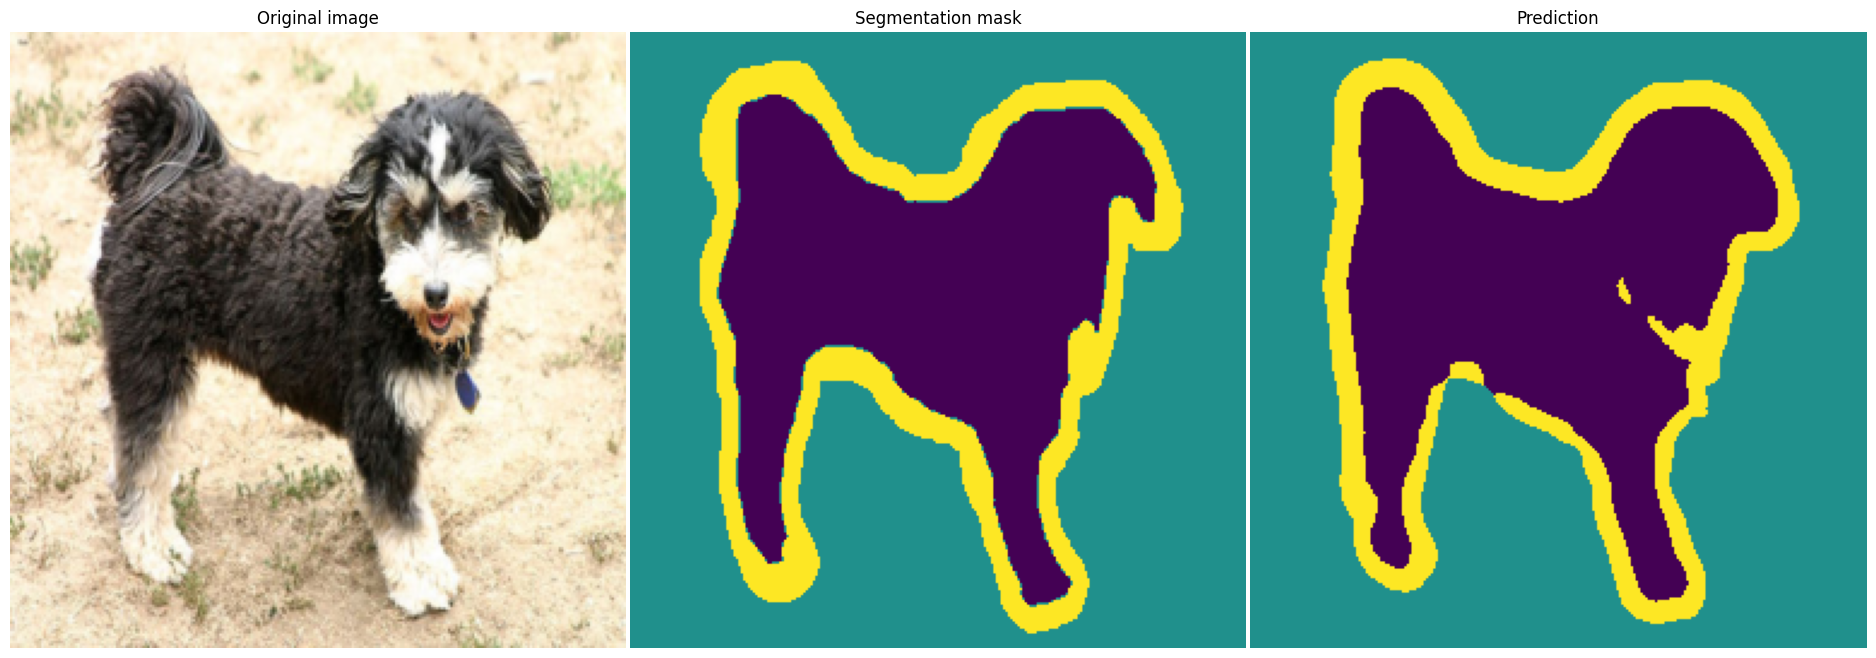

Accuracy on test: 0.8952556025187175


In [16]:
whole_train_valid_cycle(model, 30, 'UNET segmentation')